**Importing data**

In [50]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm
from keras.preprocessing import image
from keras.applications import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

In [2]:
# load train and test dataset

def path_to_tensor(folder,img_path):
    path=os.path.join(folder,img_path+'.jpg')
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)
  
def paths_to_tensor(folder,img_paths):
  list_of_tensors=[path_to_tensor(folder,img_path) for img_path in tqdm(img_paths)]
  return np.vstack(list_of_tensors)

def load_dataset(folder,img_paths):
  return paths_to_tensor(folder,img_paths).astype('float32')/255
  
  
labels=pd.read_csv('../input/labels.csv')
sample_submission=pd.read_csv('../input/sample_submission.csv')
train_target=load_dataset('../input/train',list(labels['id'].values))
train_labels=labels['breed'].values
# test_target=load_dataset('test',list(sample_submission['id'].values))

100%|██████████| 10222/10222 [01:02<00:00, 163.92it/s]


In [3]:
from sklearn.model_selection import train_test_split

X_train,X_valid,Y_train,Y_valid=train_test_split(train_target,train_labels,test_size=0.15,random_state=1)

print('Training images:',X_train.shape)
print('Training classes:',np.unique(Y_train).shape)
print('Validation images:',X_valid.shape)
print('Validation classes:',np.unique(Y_valid).shape)

Training images: (8688, 224, 224, 3)
Training classes: (120,)
Validation images: (1534, 224, 224, 3)
Validation classes: (120,)


**Visualing The Data**

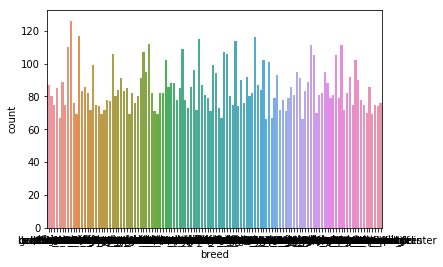

In [5]:
# Entire dataset classes
sns.countplot(x='breed',data=labels)
plt.show()

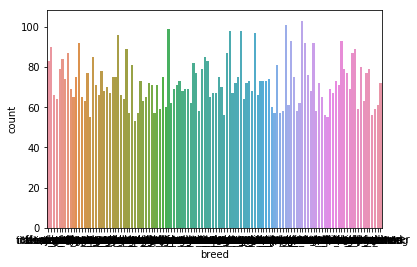

In [7]:
# Training dataset classes
df=pd.DataFrame(data=Y_train.reshape(-1,1),columns=['breed'])
sns.countplot(x='breed',data=df)
plt.show()

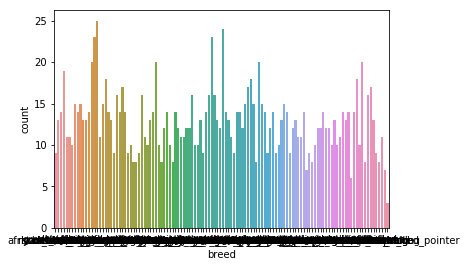

In [4]:
# Validation dataset classes
df=pd.DataFrame(data=Y_valid.reshape(-1,1),columns=['breed'])
sns.countplot(x='breed',data=df)
plt.show()

**Preprocessing data**

In [5]:
#  Encode the classes

def convert_to_one_hot(Y,C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

#  dict of dogs breed names
keys = np.unique(Y_train)
values = [x for x in range(120)]
dogs_classifier = {k:v for (k,v) in zip(keys,values)}

Y_train=np.array([dogs_classifier[x] for x in Y_train])
Y_valid=np.array([dogs_classifier[x] for x in Y_valid])

Y_train=convert_to_one_hot(Y_train,120).T
Y_valid=convert_to_one_hot(Y_valid,120).T


In [6]:
# Delete variable to clear memory because of kernel failure
del train_target

**Transfer Learning( Xception )**

In [7]:
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, 
                                        pooling='avg',input_shape=(224,224,3))

In [8]:
xception_bottleneck.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [9]:
# Train model for training and validation data
xception_bottleneck_predictions = xception_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_bottleneck_predictions = xception_bottleneck.predict(X_valid, batch_size=32, verbose=1)

1534/1534 [==============================] - 354s 231ms/step


In [10]:
print(xception_bottleneck_predictions.shape)
print(valid_bottleneck_predictions.shape)

(8688, 2048)
(1534, 2048)


**Model - 1**

78% validation accuracy

In [11]:
xception_model = Sequential()

xception_model.add(Dense(1000,activation='relu',input_shape=(2048,)))
xception_model.add(Dropout(0.3))
xception_model.add(Dense(120, activation='softmax'))

xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               120120    
Total params: 2,169,120
Trainable params: 2,169,120
Non-trainable params: 0
_________________________________________________________________


In [12]:
from keras.optimizers import Adam, Adamax

xception_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002), metrics=['accuracy'])

In [13]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='model-1.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 30
batch_size = 64

history = xception_model.fit(xception_bottleneck_predictions, Y_train, 
                            validation_data=(valid_bottleneck_predictions, Y_valid),
                            epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 8688 samples, validate on 1534 samples
Epoch 1/30
8688/8688 [==============================] - 5s 593us/step - loss: 1.3576 - acc: 0.6583 - val_loss: 0.8243 - val_acc: 0.7653

Epoch 00001: val_loss improved from inf to 0.82429, saving model to model-1.hdf5
Epoch 2/30
8688/8688 [==============================] - 4s 426us/step - loss: 0.6656 - acc: 0.7989 - val_loss: 0.7959 - val_acc: 0.7718

Epoch 00002: val_loss improved from 0.82429 to 0.79591, saving model to model-1.hdf5
Epoch 3/30
8688/8688 [==============================] - 4s 417us/step - loss: 0.5325 - acc: 0.8348 - val_loss: 0.7756 - val_acc: 0.7757

Epoch 00003: val_loss improved from 0.79591 to 0.77564, saving model to model-1.hdf5
Epoch 4/30
8688/8688 [==============================] - 4s 422us/step - loss: 0.4351 - acc: 0.8613 - val_loss: 0.8048 - val_acc: 0.7784

Epoch 00004: val_loss did not improve from 0.77564
Epoch 5/30
8688/8688 [==============================] - 4s 443us/step - loss: 0.3685 - acc: 0.8840 - v

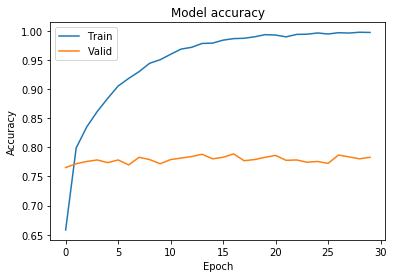

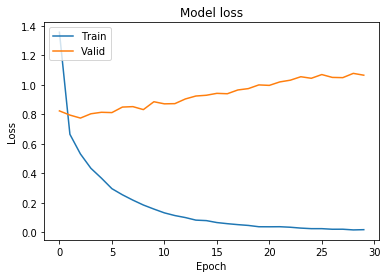

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

**Model - 2**

79%  validation accuracy

In [34]:
xception_model = Sequential()

xception_model.add(Dense(1000,activation='relu',input_shape=(2048,)))
xception_model.add(BatchNormalization())
xception_model.add(Dropout(0.2))
xception_model.add(Dense(500, activation='relu'))
xception_model.add(BatchNormalization())
xception_model.add(Dropout(0.3))
xception_model.add(Dense(120, activation='softmax'))
xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
batch_normalization_13 (Batc (None, 1000)              4000      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 120)               120120    
Total params: 2,173,120
Trainable params: 2,171,120
Non-trainable params: 2,000
_________________________________________________________________


In [35]:
from keras.optimizers import Adam, Adamax

xception_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002), metrics=['accuracy'])

In [36]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='model-2.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 10
batch_size = 64

history = xception_model.fit(xception_bottleneck_predictions, Y_train, 
                            validation_data=(valid_bottleneck_predictions, Y_valid),
                            epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 8688 samples, validate on 1534 samples
Epoch 1/10
8688/8688 [==============================] - 6s 655us/step - loss: 1.3772 - acc: 0.6611 - val_loss: 0.9005 - val_acc: 0.7614

Epoch 00001: val_loss improved from inf to 0.90054, saving model to model-2.hdf5
Epoch 2/10
8688/8688 [==============================] - 4s 455us/step - loss: 0.6785 - acc: 0.8027 - val_loss: 0.8434 - val_acc: 0.7699

Epoch 00002: val_loss improved from 0.90054 to 0.84339, saving model to model-2.hdf5
Epoch 3/10
8688/8688 [==============================] - 4s 460us/step - loss: 0.5402 - acc: 0.8381 - val_loss: 0.8408 - val_acc: 0.7777

Epoch 00003: val_loss improved from 0.84339 to 0.84078, saving model to model-2.hdf5
Epoch 4/10
8688/8688 [==============================] - 4s 455us/step - loss: 0.4472 - acc: 0.8608 - val_loss: 0.8411 - val_acc: 0.7771

Epoch 00004: val_loss did not improve from 0.84078
Epoch 5/10
8688/8688 [==============================] - 4s 458us/step - loss: 0.3561 - acc: 0.8835 - v

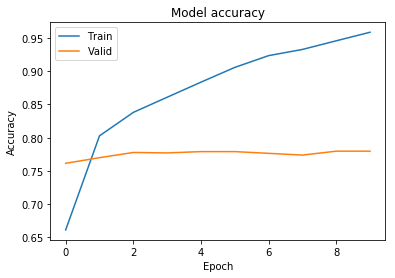

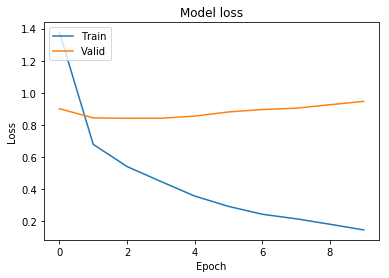

In [37]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

**Transfer Learning (Inception resnet)**

In [59]:
inception_bottleneck = inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet',
                                                            input_shape=(224,224,3) , pooling='avg')

In [60]:
inception_bottleneck.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_509 (Conv2D)             (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_518 (BatchN (None, 111, 111, 32) 96          conv2d_509[0][0]                 
__________________________________________________________________________________________________
activation_501 (Activation)     (None, 111, 111, 32) 0           batch_normalization_518[0][0]    
__________________________________________________________________________________________________
conv2d_510

Non-trainable params: 60,544
__________________________________________________________________________________________________


In [62]:
# Train model for training and validation data
inception_bottleneck_predictions = inception_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_bottleneck_predictions = inception_bottleneck.predict(X_valid, batch_size=32, verbose=1)

1534/1534 [==============================] - 301s 196ms/step


In [63]:
print(inception_bottleneck_predictions.shape)
print(valid_bottleneck_predictions.shape)

(8688, 1536)
(1534, 1536)


**Model - 3**

83%  Validation accuracy

In [64]:
inception_model = Sequential()

inception_model.add(Dense(1000,activation='relu',input_shape=(1536,)))
inception_model.add(BatchNormalization())
inception_model.add(Dropout(0.2))
inception_model.add(Dense(500, activation='relu'))
inception_model.add(BatchNormalization())
inception_model.add(Dropout(0.3))
inception_model.add(Dense(120, activation='softmax'))
inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1000)              1537000   
_________________________________________________________________
batch_normalization_721 (Bat (None, 1000)              4000      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 500)               500500    
_________________________________________________________________
batch_normalization_722 (Bat (None, 500)               2000      
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               60120     
Total para

In [65]:
from keras.optimizers import Adam, Adamax

inception_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002), metrics=['accuracy'])

In [83]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='model-3.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 10
batch_size = 64

history = inception_model.fit(inception_bottleneck_predictions, Y_train, 
                            validation_data=(valid_bottleneck_predictions, Y_valid),
                            epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 8688 samples, validate on 1534 samples
Epoch 1/10
8688/8688 [==============================] - 6s 717us/step - loss: 0.0140 - acc: 0.9949 - val_loss: 1.4379 - val_acc: 0.8149

Epoch 00001: val_loss improved from inf to 1.43791, saving model to model-3.hdf5
Epoch 2/10
8688/8688 [==============================] - 6s 711us/step - loss: 0.0166 - acc: 0.9940 - val_loss: 1.4391 - val_acc: 0.8070

Epoch 00002: val_loss did not improve from 1.43791
Epoch 3/10
8688/8688 [==============================] - 6s 697us/step - loss: 0.0137 - acc: 0.9960 - val_loss: 1.4350 - val_acc: 0.8096

Epoch 00003: val_loss improved from 1.43791 to 1.43497, saving model to model-3.hdf5
Epoch 4/10
8688/8688 [==============================] - 6s 701us/step - loss: 0.0139 - acc: 0.9955 - val_loss: 1.4658 - val_acc: 0.8162

Epoch 00004: val_loss did not improve from 1.43497
Epoch 5/10
8688/8688 [==============================] - 6s 702us/step - loss: 0.0145 - acc: 0.9954 - val_loss: 1.4546 - val_acc: 0.8096


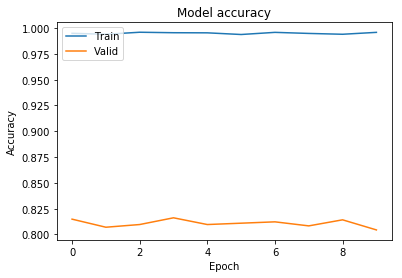

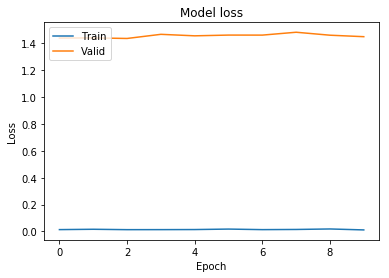

In [84]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()